Authors : Rayane KADEM

This noteBook groups all tested models for MFCC spectrogram representation technique, starting from VGG16 transfer learning, VGG16+SVM, 2Layers CNN model and 3Layers CNN model.

The notebook was ran on Google colab, thus you will find commands about relating the environment to Google drive for storing and exchanging the data from and towards the drive.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install patool

     |████████████████████████████████| 77 kB 3.3 MB/s 


#TQDM Mode


In [ ]:
import patoolib
patoolib.extract_archive("/content/drive/MyDrive/mfcc.rar", outdir="/content")

patool: Extracting /content/drive/MyDrive/mfcc.rar ...
patool: running /usr/bin/unrar x -- /content/drive/MyDrive/mfcc.rar
patool:     with cwd='/content'
patool: ... /content/drive/MyDrive/mfcc.rar extracted to `/content'.


'/content'

In [ ]:

# Importing the required libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from fetch_training_dataset import fetch_spectogram_dataset
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
#import argparse
import keras
from keras.layers import Flatten, Dense, Dropout, Conv2D, Activation ,MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping
from fetch_training_dataset import prep_data_images


In [ ]:
data = prep_data_images()
#data.prep_data("/content/mfcc",(224,124))
data.prep_data("/content/mfcc",None)

  0%|          | 0/10 [00:00<?, ?it/s]

country



 10%|█         | 1/10 [00:00<00:06,  1.40it/s]

disco



 20%|██        | 2/10 [00:01<00:05,  1.40it/s]

hiphop



 30%|███       | 3/10 [00:02<00:05,  1.39it/s]

blues



 40%|████      | 4/10 [00:02<00:04,  1.40it/s]

classical



 50%|█████     | 5/10 [00:03<00:03,  1.41it/s]

pop



 60%|██████    | 6/10 [00:04<00:02,  1.40it/s]

rock



 70%|███████   | 7/10 [00:05<00:02,  1.39it/s]

reggae



 80%|████████  | 8/10 [00:05<00:01,  1.39it/s]

jazz



 90%|█████████ | 9/10 [00:06<00:00,  1.39it/s]

metal



100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


In [ ]:
width,height,dimension = data.Xtest[0].shape

In [ ]:
width,height,dimension

(288, 432, 3)

## Transfer learning Vgg16

In [ ]:
# Defining the black box model
class CNNModel:
    def __init__(self):
        self.model = None
        self.model_name = "transfer_learning_vgg16_model_ADAM_crossEn_mfcc_2"
        self.model_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + ".h5"
        self.model_weights_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+  self.model_name + "_weights.h5"
        self.model_history_path_acc = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_acc.png"
        self.model_history_path_loss = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_loss.png"
        
        self.model_history = None
    
    def build_model(self):
        """
        This function is used to create the black box model :
        """
        # Defining the input layer
        
        model = Sequential()

        vggmodel=VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(width,height,dimension), pooling=None)
        
        # Take all weights of imagenet dataset except for last four layers
        for layer in vggmodel.layers[:-8]: 
            layer.trainable = False 

        x = vggmodel.output
        x = Flatten()(x)

        x = Dense(512, activation="relu")(x)
        x = Dropout(0.4)(x)
        x = Dense(128, activation="elu")(x)
        predictions = Dense(10, activation="softmax")(x)

        # creating the final model 
        model = Model( vggmodel.input, predictions)

        # Compiling the model
        self.model = model
        
        self.model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001), loss = "categorical_crossentropy", metrics=['accuracy'])
        return vggmodel, x
    def train_model(self,data, epochs=10):
        """
        This function is used to train the black box model :
        """
        # Training the model
        self.model_history = self.model.fit(data.Xtrain,data.ytrain, epochs=epochs,validation_data=(data.Xval,data.yval), shuffle=True)
        
    def save_model(self):
        """
        This function is used to save the black box model :
        """
        # Save the model
        self.model.save(self.model_path)
        
    def load_model(self):
        """
        This function is used to load the black box model :
        """
        # Load the model
        self.model = tf.keras.models.load_model(self.model_path)
        
    def save_model_weights(self):
        """
        This function is used to save the weights of the black box model :
        """
        # Save the weights
        self.model.save_weights(self.model_weights_path)
    

    def evaluate_model(self, Xtest,ytest):
        """
        This function is used to evaluate the black box model :
        """
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(Xtest,ytest)
        print("Test loss: ", test_loss)
        print("Test accuracy: ", test_acc)
    
    def plot_model_history(self):
        """
        This function is used to plot the model history :
        """
        #define variables
        loss = self.model_history.history['loss']
        val_loss = self.model_history.history['val_loss']
        accuracy = self.model_history.history['accuracy']
        val_accuracy = self.model_history.history['val_accuracy']
        epochs = range(1, len(loss) + 1)
        # Plot the model history
        plt.figure()
        plt.plot(epochs, accuracy, label='Training accuracy')
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.savefig(self.model_history_path_acc)
        plt.show()

        plt.figure()
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.savefig(self.model_history_path_loss)
        plt.show()
        
    def predict_class(self, spectrogram_image):
        """
        This function is used to predict the class of the spectrogram image :
        """
        # Predict the class
        prediction = self.model.predict(spectrogram_image)
        return np.argmax(prediction)

    def predict_classes(self, spectrogram_images):
        """
        This function is used to predict the classes of the spectrogram images :
        """
        # Predict the classes
        predictions = self.model.predict(spectrogram_images)
        return np.argmax(predictions, axis=1)

    
    def plot_confusion_matrix(self, Xtest,ytest, classes=None):
        """
        This function is used to plot the confusion matrix :
        """
        # Predict the classes
        predictions = self.predict_classes(Xtest)
        # Plot the confusion matrix
        y_parse = np.argmax(ytest, axis=1)
        cm = confusion_matrix(y_parse, predictions)
        #if classes is None:
        #    classes = test_generator.class_indices.keys()
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(10)
        plt.xticks(tick_marks,classes,  rotation=45)
        plt.yticks(tick_marks,classes)
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig("/content/drive/MyDrive/Mymodels_result/"+ self.model_name +"/"+"confusion_matrix.png")
        plt.show()
        acc = np.diag(cm).sum() /cm.sum()
        print("acc",acc)

Epoch 1/30
22/22 [==============================] - 32s 1s/step - loss: 2.0013 - accuracy: 0.2957 - val_loss: 1.6783 - val_accuracy: 0.3800
Epoch 2/30
22/22 [==============================] - 28s 1s/step - loss: 1.5269 - accuracy: 0.4357 - val_loss: 1.5622 - val_accuracy: 0.3900
Epoch 3/30
22/22 [==============================] - 28s 1s/step - loss: 1.2547 - accuracy: 0.5514 - val_loss: 1.5671 - val_accuracy: 0.4000
Epoch 4/30
22/22 [==============================] - 28s 1s/step - loss: 0.9088 - accuracy: 0.7071 - val_loss: 1.2781 - val_accuracy: 0.5500
Epoch 6/30
22/22 [==============================] - 28s 1s/step - loss: 0.7202 - accuracy: 0.7657 - val_loss: 1.1728 - val_accuracy: 0.6200
Epoch 7/30
22/22 [==============================] - 28s 1s/step - loss: 0.6170 - accuracy: 0.7829 - val_loss: 1.2372 - val_accuracy: 0.6000
Epoch 8/30
22/22 [==============================] - 28s 1s/step - loss: 0.4667 - accuracy: 0.8457 - val_loss: 1.2005 - val_accuracy: 0.6300
Epoch 9/30
22/22 [==

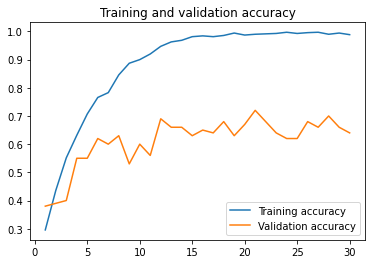

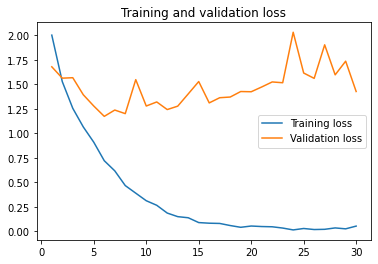

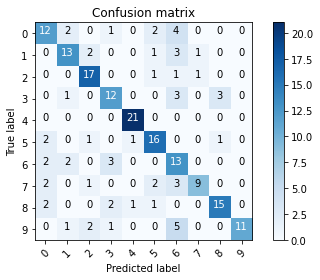

acc 0.695


In [ ]:
for i in range(1):
    
    # Fetch the training and test dataset
    
    # Create the  model
    model = CNNModel()
    
    # Build the  model
    vggmodel, model_features=model.build_model()
    # Train the  model
    model.train_model(data, epochs=30)
    
    # Save the  model
    model.save_model()

    # Evaluate  model
    model.evaluate_model(data.Xtest,data.ytest)

    # Plot the model history
    model.plot_model_history()
    
    # Plot the confusion matrix
    model.plot_confusion_matrix(data.Xtest,data.ytest)


# VGG16+SVM

#VGG16 features + SVM

In [ ]:
# Define feature extractor model
extractor = Model(model.model.input, model.model.layers[-2].output)
Xtrain = np.concatenate((data.Xtrain,data.Xval), axis=0)
# Feature extraction
xapp = extractor.predict(Xtrain) # training CNN features vector
xtest = extractor.predict(data.Xtest) # testing CNN features vector
# Normalisation
from sklearn import preprocessing 
""" MIN MAX SCALER """
min_max_scaler = preprocessing.MinMaxScaler(feature_range =(0, 1)) 
# Scaled feature 
xapp_n = min_max_scaler.fit_transform(xapp)
xtest_n = min_max_scaler.fit_transform(xtest)

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import pandas as pd
# transform labels to parse
yT  = np.argwhere(np.concatenate((data.ytrain,data.yval),axis=0))
yTr = yT[:,1] 
yT  = np.argwhere(data.ytest)
yTs = yT[:,1] 

In [ ]:
# function to find best accuracy and its related parameters Gamma and C
def best_value(tmbr,G,C):
  acc= tmbr.max()
  result = np.where(tmbr_all == acc)
  coor = list(zip(result[0], result[1]))
  g=G[coor[0][0]]
  c= C[coor[0][1]]
  return acc,g,c

In [ ]:
#Grid search ofSVM

# Set a range for C values
C2 = np.array([100,200,500,1000,2015])
C1 = np.arange(1, 40,2)
C=np.append(C1,C2)
m=len(C)
# Set a range for Gamma values
G1 = np.array([0.00001,0.0001,0.001,0.01,0.1,0.2,0.5,1])  #
G2 = np.arange(2, 6, 1)  
G=np.append(G1,G2) 
n=len(G)

i=0
j=0
tmbr_all = np.zeros((n,m))
for C_value in C:
    for g_value in G:
    
        clf = svm.SVC(kernel='rbf', C=C_value, gamma=g_value)
        clf.fit(xapp_n, yTr)
        predicted = clf.predict(xtest_n)
        tmbr = accuracy_score(predicted,yTs)
        print(tmbr*100, C_value, g_value)
        tmbr_all[i,j] = tmbr
        i=i+1
    i=0
    j=j+1
acc, g,c = best_value(tmbr_all,G,C)
print("accuracy:", acc)
print("best params : gamma = ",g,",C =",c)

8.5 1 1e-05
8.5 1 0.0001
35.0 1 0.001
69.5 1 0.01
69.5 1 0.1
70.0 1 0.2
66.5 1 0.5
45.0 1 1.0
25.0 1 2.0
11.5 1 3.0
10.5 1 4.0
9.0 1 5.0
8.5 3 1e-05
8.5 3 0.0001
70.5 3 0.001
70.0 3 0.01
69.5 3 0.1
68.5 3 0.2
66.5 3 0.5
45.5 3 1.0
26.0 3 2.0
12.5 3 3.0
11.0 3 4.0
10.5 3 5.0
8.5 5 1e-05
9.5 5 0.0001
71.0 5 0.001
70.0 5 0.01
69.0 5 0.1
69.5 5 0.2
66.5 5 0.5
45.5 5 1.0
26.0 5 2.0
12.5 5 3.0
11.0 5 4.0
10.5 5 5.0
8.5 7 1e-05
18.5 7 0.0001
70.5 7 0.001
69.5 7 0.01
69.5 7 0.1
69.5 7 0.2
66.5 7 0.5
45.5 7 1.0
26.0 7 2.0
12.5 7 3.0
11.0 7 4.0
10.5 7 5.0
8.5 9 1e-05
26.0 9 0.0001
70.0 9 0.001
70.5 9 0.01
70.0 9 0.1
69.5 9 0.2
66.5 9 0.5
45.5 9 1.0
26.0 9 2.0
12.5 9 3.0
11.0 9 4.0
10.5 9 5.0
8.5 11 1e-05
46.5 11 0.0001
69.0 11 0.001
70.5 11 0.01
70.0 11 0.1
69.5 11 0.2
66.5 11 0.5
45.5 11 1.0
26.0 11 2.0
12.5 11 3.0
11.0 11 4.0
10.5 11 5.0
8.5 13 1e-05
58.5 13 0.0001
69.5 13 0.001
71.0 13 0.01
69.5 13 0.1
69.5 13 0.2
66.5 13 0.5
45.5 13 1.0
26.0 13 2.0
12.5 13 3.0
11.0 13 4.0
10.5 13 5.0
8.5 15 

## 2 Layers CNN model 

In [ ]:
width,height,dimenstion = data.Xtrain[0].shape

In [ ]:
# Defining the black box model
class CNNModel:
    def __init__(self):
        self.model = None
        self.model_name = "2layersCNN_ADAM_crossEn_mfcc_ADAM_CrossEnt"
        self.model_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + ".h5"
        self.model_weights_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+  self.model_name + "_weights.h5"
        self.model_history_path_acc = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_acc.png"
        self.model_history_path_loss = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_loss.png"
        
        self.model_history = None
    
    def build_model(self):
        """
        This function is used to create the black box model :
        """
        # Defining the input layer
        
        model = Sequential()

        #Adding the CNN layers along with some drop outs and maxpooling
        
        model.add(Conv2D(64, (3,3), activation ='relu', input_shape =(width,height,dimenstion)))
        model.add(MaxPooling2D(pool_size = (2,2)))


        model.add(Conv2D(32, (3,3),strides=(1,1) , activation = 'relu'))
        model.add(MaxPooling2D(pool_size = (2,2)))
        
        model.add(Flatten())

        
        #Adding the dense layers
        model.add(Dense(256, activation = 'relu'))
        model.add(Dropout(0.5))
        model.add(Dense(124, activation = 'relu'))
        #final output layer with 10 predictions to be made
        model.add(Dense(10, activation = 'softmax'))
    
        
        
        # Compiling the model
        self.model = model
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

    def train_model(self,data, epochs=10):
        """
        This function is used to train the black box model :
        """
        # Training the model
        self.model_history = self.model.fit(data.Xtrain,data.ytrain, epochs=epochs,validation_data=(data.Xval,data.yval), shuffle=True)
        
    def save_model(self):
        """
        This function is used to save the black box model :
        """
        # Save the model
        self.model.save(self.model_path)
        
    def load_model(self):
        """
        This function is used to load the black box model :
        """
        # Load the model
        self.model = tf.keras.models.load_model(self.model_path)
        
    def save_model_weights(self):
        """
        This function is used to save the weights of the black box model :
        """
        # Save the weights
        self.model.save_weights(self.model_weights_path)
    

    def evaluate_model(self, Xtest,ytest):
        """
        This function is used to evaluate the black box model :
        """
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(Xtest,ytest)
        print("Test loss: ", test_loss)
        print("Test accuracy: ", test_acc)
    
    def plot_model_history(self):
        """
        This function is used to plot the model history :
        """
        #define variables
        loss = self.model_history.history['loss']
        val_loss = self.model_history.history['val_loss']
        accuracy = self.model_history.history['accuracy']
        val_accuracy = self.model_history.history['val_accuracy']
        epochs = range(1, len(loss) + 1)
        # Plot the model history
        plt.figure()
        plt.plot(epochs, accuracy, label='Training accuracy')
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.savefig(self.model_history_path_acc)
        plt.show()

        plt.figure()
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.savefig(self.model_history_path_loss)
        plt.show()
        
    def predict_class(self, spectrogram_image):
        """
        This function is used to predict the class of the spectrogram image :
        """
        # Predict the class
        prediction = self.model.predict(spectrogram_image)
        return np.argmax(prediction)

    def predict_classes(self, spectrogram_images):
        """
        This function is used to predict the classes of the spectrogram images :
        """
        # Predict the classes
        predictions = self.model.predict(spectrogram_images)
        return np.argmax(predictions, axis=1)

    
    def plot_confusion_matrix(self, Xtest,ytest, classes=None):
        """
        This function is used to plot the confusion matrix :
        """
        # Predict the classes
        predictions = self.predict_classes(Xtest)
        # Plot the confusion matrix
        y_parse = np.argmax(ytest, axis=1)
        cm = confusion_matrix(y_parse, predictions)
        #if classes is None:
        #    classes = test_generator.class_indices.keys()
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(10)
        plt.xticks(tick_marks,classes,  rotation=45)
        plt.yticks(tick_marks,classes)
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig("/content/drive/MyDrive/Mymodels_result/"+ self.model_name +"/"+"confusion_matrix.png")
        plt.show()
        acc = np.diag(cm).sum() /cm.sum()
        print("acc",acc)

Epoch 1/150
22/22 [==============================] - 18s 376ms/step - loss: 2.3260 - accuracy: 0.1243 - val_loss: 2.2634 - val_accuracy: 0.1200
Epoch 2/150
22/22 [==============================] - 6s 270ms/step - loss: 2.2898 - accuracy: 0.1386 - val_loss: 2.2443 - val_accuracy: 0.1600
Epoch 3/150
22/22 [==============================] - 6s 272ms/step - loss: 2.2449 - accuracy: 0.1900 - val_loss: 2.2055 - val_accuracy: 0.2600
Epoch 4/150
22/22 [==============================] - 6s 270ms/step - loss: 2.1807 - accuracy: 0.2357 - val_loss: 2.1621 - val_accuracy: 0.3000
Epoch 5/150
22/22 [==============================] - 6s 273ms/step - loss: 2.1151 - accuracy: 0.2914 - val_loss: 2.1233 - val_accuracy: 0.2700
Epoch 6/150
22/22 [==============================] - 6s 271ms/step - loss: 2.0803 - accuracy: 0.2900 - val_loss: 2.0770 - val_accuracy: 0.2900
Epoch 7/150
22/22 [==============================] - 6s 272ms/step - loss: 2.0382 - accuracy: 0.3029 - val_loss: 2.0477 - val_accuracy: 0.370

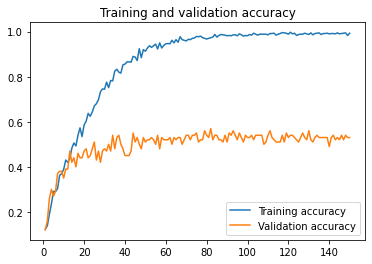

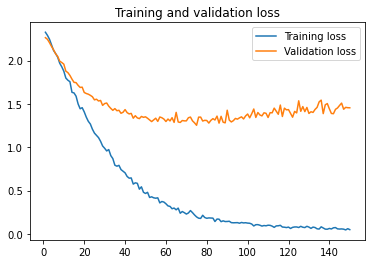

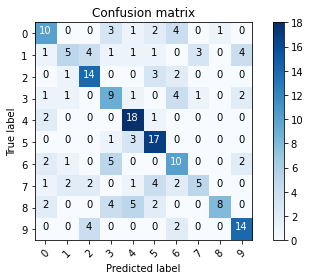

acc 0.55


In [ ]:
for i in range(1):
    
    # Fetch the training and test dataset
    
    # Create the  model
    model = CNNModel()
    
    # Build the  model
    model.build_model()
    # Train the  model
    model.train_model(data, epochs=150)
    
    # Save the  model
    model.save_model()

    # Evaluate  model
    model.evaluate_model(data.Xtest,data.ytest)

    # Plot the model history
    model.plot_model_history()
    
    # Plot the confusion matrix
    model.plot_confusion_matrix(data.Xtest,data.ytest)


## 2 Layers CNN model 

In [ ]:
width,height,dimenstion = data.Xtrain[0].shape

In [ ]:
# Defining the black box model
class CNNModel:
    def __init__(self):
        self.model = None
        self.model_name = "2layersCNN_ADAM_crossEn_mfcc_ADAM_CrossEnt"
        self.model_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + ".h5"
        self.model_weights_path = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+  self.model_name + "_weights.h5"
        self.model_history_path_acc = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_acc.png"
        self.model_history_path_loss = "/content/drive/MyDrive/Mymodels_result/" + self.model_name +"/"+ self.model_name + "_history_loss.png"
        
        self.model_history = None
    
    def build_model(self):
        """
        This function is used to create the black box model :
        """
        # Defining the input layer
        
        model = Sequential()

        #Adding the CNN layers along with some drop outs and maxpooling
        
        model.add(Conv2D(64, (3,3), activation ='relu', input_shape =(width,height,dimenstion)))
        model.add(MaxPooling2D(pool_size = (2,2)))


        model.add(Conv2D(32, (3,3),strides=(1,1) , activation = 'relu'))
        model.add(MaxPooling2D(pool_size = (2,2)))
        
        model.add(Flatten())

        
        #Adding the dense layers
        model.add(Dense(256, activation = 'relu'))
        model.add(Dropout(0.5))
        model.add(Dense(124, activation = 'relu'))
        #final output layer with 10 predictions to be made
        model.add(Dense(10, activation = 'softmax'))
    
        
        
        # Compiling the model
        self.model = model
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

    def train_model(self,data, epochs=10):
        """
        This function is used to train the black box model :
        """
        # Training the model
        self.model_history = self.model.fit(data.Xtrain,data.ytrain, epochs=epochs,validation_data=(data.Xval,data.yval), shuffle=True)
        
    def save_model(self):
        """
        This function is used to save the black box model :
        """
        # Save the model
        self.model.save(self.model_path)
        
    def load_model(self):
        """
        This function is used to load the black box model :
        """
        # Load the model
        self.model = tf.keras.models.load_model(self.model_path)
        
    def save_model_weights(self):
        """
        This function is used to save the weights of the black box model :
        """
        # Save the weights
        self.model.save_weights(self.model_weights_path)
    

    def evaluate_model(self, Xtest,ytest):
        """
        This function is used to evaluate the black box model :
        """
        # Evaluate the model
        test_loss, test_acc = self.model.evaluate(Xtest,ytest)
        print("Test loss: ", test_loss)
        print("Test accuracy: ", test_acc)
    
    def plot_model_history(self):
        """
        This function is used to plot the model history :
        """
        #define variables
        loss = self.model_history.history['loss']
        val_loss = self.model_history.history['val_loss']
        accuracy = self.model_history.history['accuracy']
        val_accuracy = self.model_history.history['val_accuracy']
        epochs = range(1, len(loss) + 1)
        # Plot the model history
        plt.figure()
        plt.plot(epochs, accuracy, label='Training accuracy')
        plt.plot(epochs, val_accuracy, label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.savefig(self.model_history_path_acc)
        plt.show()

        plt.figure()
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        plt.savefig(self.model_history_path_loss)
        plt.show()
        
    def predict_class(self, spectrogram_image):
        """
        This function is used to predict the class of the spectrogram image :
        """
        # Predict the class
        prediction = self.model.predict(spectrogram_image)
        return np.argmax(prediction)

    def predict_classes(self, spectrogram_images):
        """
        This function is used to predict the classes of the spectrogram images :
        """
        # Predict the classes
        predictions = self.model.predict(spectrogram_images)
        return np.argmax(predictions, axis=1)

    
    def plot_confusion_matrix(self, Xtest,ytest, classes=None):
        """
        This function is used to plot the confusion matrix :
        """
        # Predict the classes
        predictions = self.predict_classes(Xtest)
        # Plot the confusion matrix
        y_parse = np.argmax(ytest, axis=1)
        cm = confusion_matrix(y_parse, predictions)
        #if classes is None:
        #    classes = test_generator.class_indices.keys()
        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(10)
        plt.xticks(tick_marks,classes,  rotation=45)
        plt.yticks(tick_marks,classes)
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig("/content/drive/MyDrive/Mymodels_result/"+ self.model_name +"/"+"confusion_matrix.png")
        plt.show()
        acc = np.diag(cm).sum() /cm.sum()
        print("acc",acc)

Epoch 1/150
22/22 [==============================] - 18s 376ms/step - loss: 2.3260 - accuracy: 0.1243 - val_loss: 2.2634 - val_accuracy: 0.1200
Epoch 2/150
22/22 [==============================] - 6s 270ms/step - loss: 2.2898 - accuracy: 0.1386 - val_loss: 2.2443 - val_accuracy: 0.1600
Epoch 3/150
22/22 [==============================] - 6s 272ms/step - loss: 2.2449 - accuracy: 0.1900 - val_loss: 2.2055 - val_accuracy: 0.2600
Epoch 4/150
22/22 [==============================] - 6s 270ms/step - loss: 2.1807 - accuracy: 0.2357 - val_loss: 2.1621 - val_accuracy: 0.3000
Epoch 5/150
22/22 [==============================] - 6s 273ms/step - loss: 2.1151 - accuracy: 0.2914 - val_loss: 2.1233 - val_accuracy: 0.2700
Epoch 6/150
22/22 [==============================] - 6s 271ms/step - loss: 2.0803 - accuracy: 0.2900 - val_loss: 2.0770 - val_accuracy: 0.2900
Epoch 7/150
22/22 [==============================] - 6s 272ms/step - loss: 2.0382 - accuracy: 0.3029 - val_loss: 2.0477 - val_accuracy: 0.370

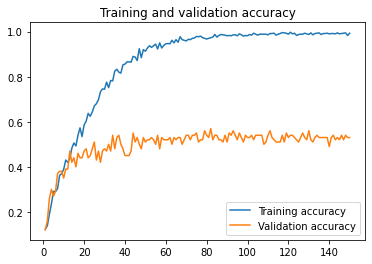

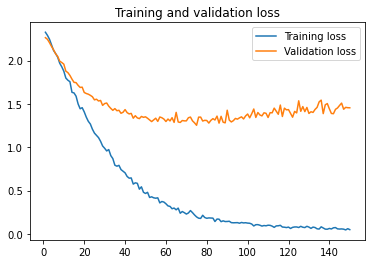

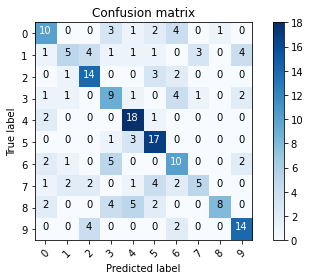

acc 0.55


In [ ]:
for i in range(1):
    
    # Fetch the training and test dataset
    
    # Create the  model
    model = CNNModel()
    
    # Build the  model
    model.build_model()
    # Train the  model
    model.train_model(data, epochs=150)
    
    # Save the  model
    model.save_model()

    # Evaluate  model
    model.evaluate_model(data.Xtest,data.ytest)

    # Plot the model history
    model.plot_model_history()
    
    # Plot the confusion matrix
    model.plot_confusion_matrix(data.Xtest,data.ytest)
